In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import yaml
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from utils import get_contribution, plot_heatmap_with_bar_plot
from itertools import product


warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 


_IN_STUDY = {
    "kim_lung": ("Kim_3",),
    "neftel_smartseq2_brain": ("Neftel_4", "Neftel_6"),
    "neftel_10x_brain": ("Neftel_4", "Neftel_6"),
    "wu_breast": ("Wu_4", "Wu_6"),
    "ji_skin": ("Ji_3",),
    #"vazquez_ovarian": ("Vazquez_6",)
}

_IN_STUDY_ORDER = ('Ji (3)', 'Neftel, SS2 (4)', 'Neftel, SS2 (6)', 'Neftel, 10X (4)',
       'Neftel, 10X (6)', 'Kim (3)', 'Wu (4)', 'Wu (6)')

In [3]:
figure_config = yaml.safe_load(open("figures_config.yml", "r"))
dataset_map = figure_config["datasets"]
method_order = figure_config["method_order"]
method_colormap = figure_config["method_colormap"]
methods_map = figure_config["methods"]
scenarios = {}

for config_path in pathlib.Path("../configs").iterdir():
    if config_path.stem == "config":
        continue
    config = yaml.safe_load(open(config_path, "r"))
    for scenario, values in config["scenarios"].items():
        values["root"] = config["root"]
        if "gbm_subsample" in config["root"]:
            continue
        scenarios[scenario] = values


In [4]:
path_scores = "../{root}/scores/type/scrna/{study}.csv"

scores = []
for study, sigs in _IN_STUDY.items():
    for sig in sigs:
        file_path = path_scores.format(root=scenarios[study]["root"], study=study)
        df = pd.read_csv(file_path)
        df["Dataset"] = dataset_map[study]
        df = df[df["Signature"]==sig].copy()
        if df.shape[0] == 0:
            raise ValueError("Signature not found.")
        scores.append(df)
df = pd.concat(scores, axis=0)
df["#Cluster"] = df["Cluster"] - df["Signature"].str.rsplit("_", n=1).str[1].astype(int)
df["Dataset"] = df["Dataset"].astype(str) + " (" + df["Signature"].str.rsplit("_", n=1).str[1].astype(str) + ")"
df = df.drop(["Signature", "Cluster", "Split"], axis=1)
df = df.set_index(["Dataset", "#Cluster"])
df = df.unstack()
df = df.rename(columns=methods_map)
df = df.sort_index(key=lambda x: x.map(method_order.index), axis=1, level=0)
df = df.sort_index(key=lambda x: x.map(_IN_STUDY_ORDER.index))
method_order = list(filter(lambda x: x in df.columns, method_order))



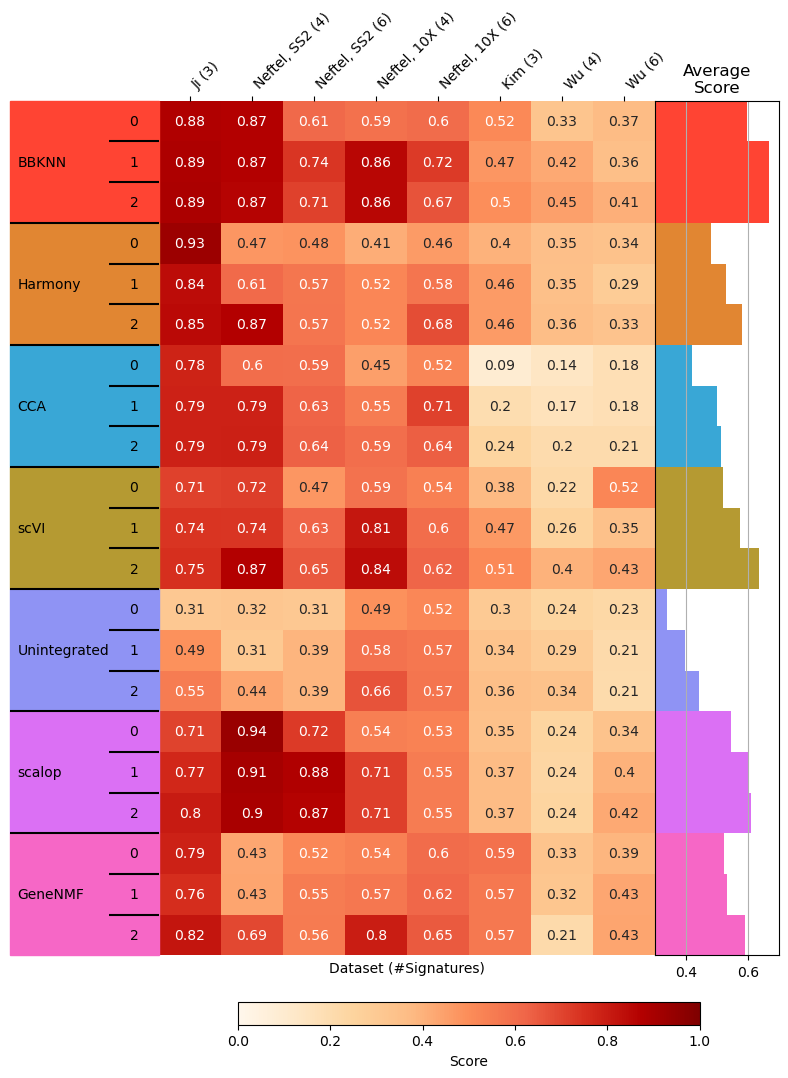

In [5]:

fig = plot_heatmap_with_bar_plot(df)
fig.savefig("fig_3/fig3_overview.svg", bbox_inches="tight")

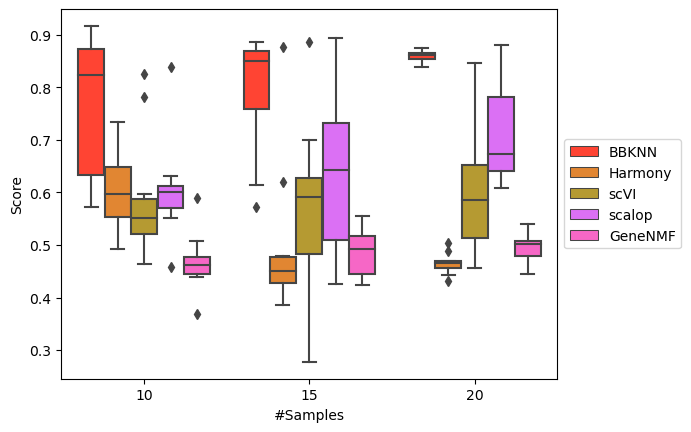

In [6]:
scores = pd.read_csv("../results/gbm_subsample/scores/type/scrna/neftel_smartseq2_brain.csv")
subset = scores.copy()
subset["random_seed"] = subset["Split"].str.rsplit("_", n=2).str[2]
subset["n_patients"] = subset["Split"].str.rsplit("_", n=2).str[1]
subset = subset[subset["Signature"] == "Neftel_4"]
subset = subset[subset["Cluster"]==4]
subset = subset.drop(["Signature", "Split", "Cluster"], axis=1)
#subset = subset.groupby(["n_patients", "random_seed"]).max().reset_index()
subset["n_patients"] = subset["n_patients"].astype(int)
subset = subset[subset["n_patients"]>5]

# %%
subset = subset.rename(columns=methods_map)
value_vars = [methods_map[key] for key in ["bbknn", "harmony", "scvi", "scalop", "genenmf"]]
subset = subset.melt(id_vars=["n_patients", "random_seed"], value_vars=value_vars)
# %%
fig, ax = plt.subplots()
g = sns.boxplot(subset, x="n_patients", y="value", hue="variable", palette=method_colormap, ax=ax, saturation=1)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("Score")
ax.set_xlabel("#Samples")
fig.savefig("fig_3/barplot.svg", bbox_inches="tight")

plt.show()

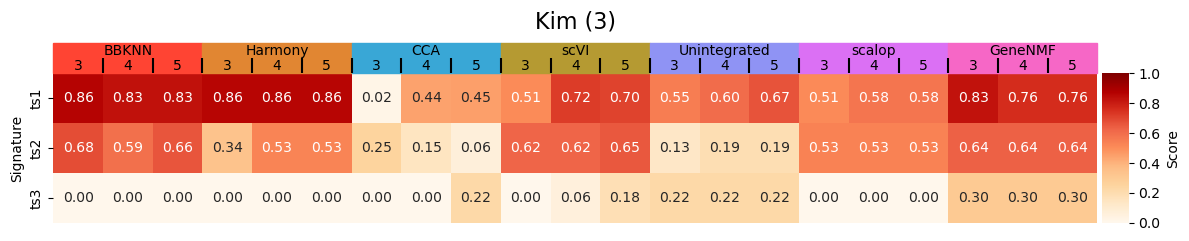

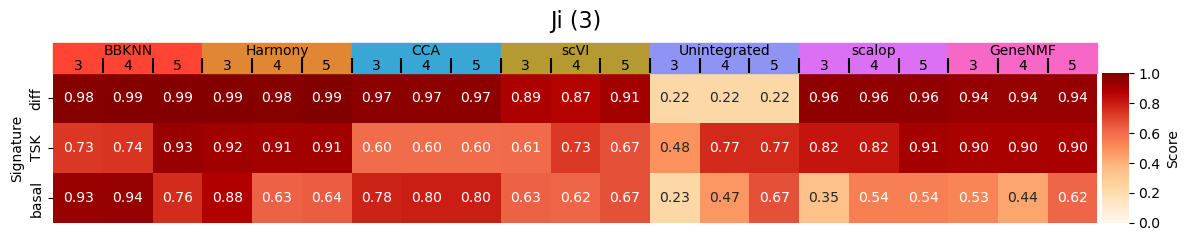

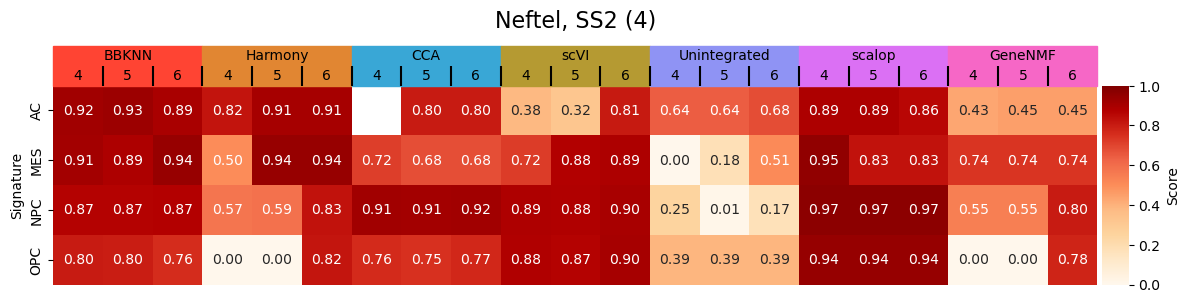

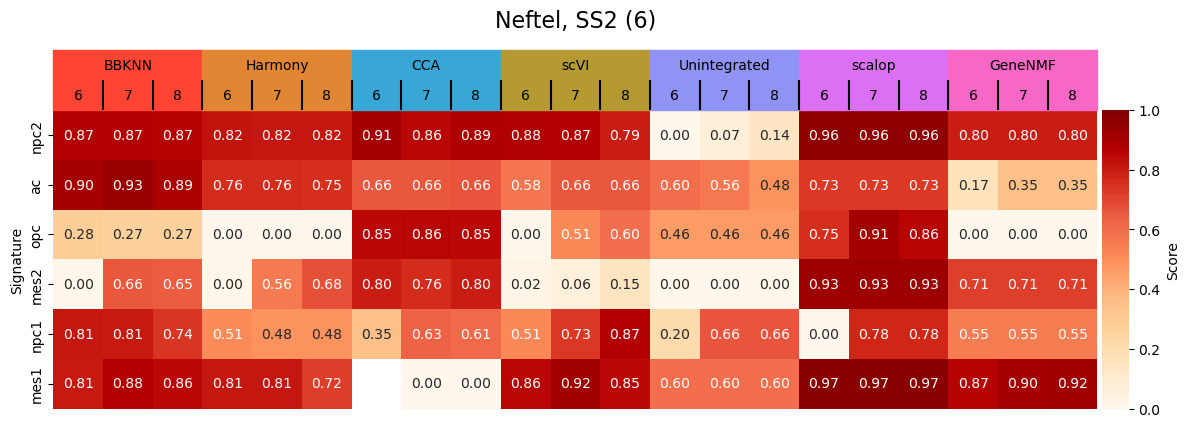

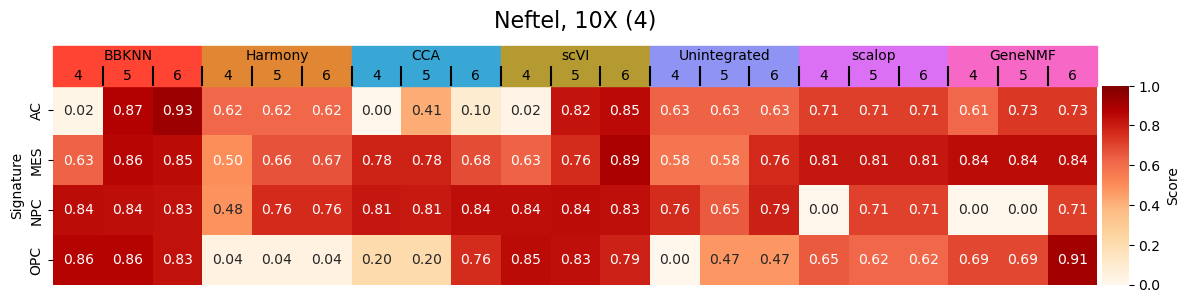

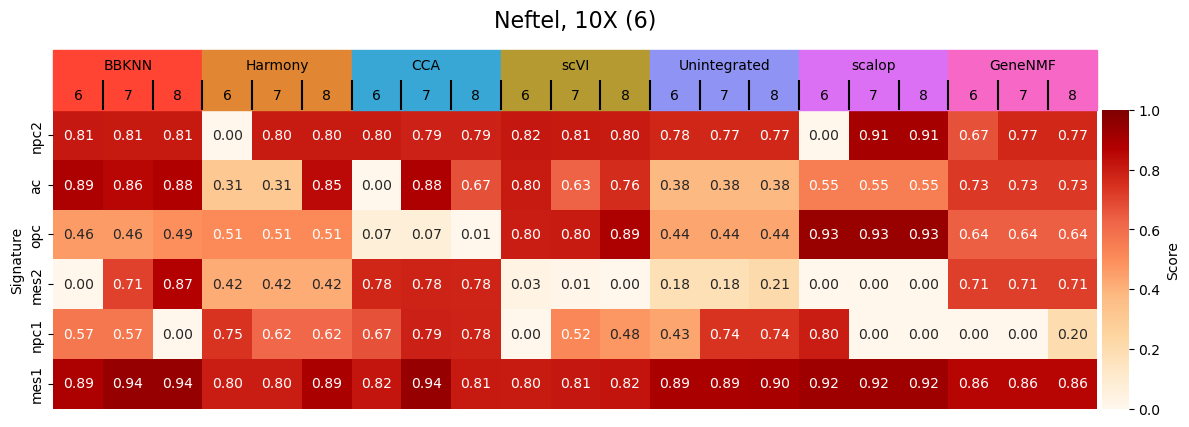

In [22]:
scens = {("luad", "kim_lung"): ("kim_3",),
("scc", "ji_skin"): ("ji_3",),
("gbm","neftel_smartseq2_brain"): ("neftel_4", "neftel_6"),
("gbm","neftel_10x_brain"): ("neftel_4", "neftel_6")}
for (cancer_type, scenario), signatures in scens.items():
    for signature in signatures:
        results = get_contribution(cancer_type, scenario, signature)
        results.index.name = "Method"
        results = results.reset_index()
        results["Method"] = results["Method"].map(methods_map.get)
        results["Method"] = pd.Categorical(results['Method'], categories=method_order, ordered=True)
        results = results.sort_values(by=['Method', '#Cluster'], ascending=[True, True])
        results = results.reset_index().set_index(["Method", "#Cluster"]).transpose()
        df = results.drop("index")
        fig, ax = plt.subplots(figsize=(12, 6))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2.5%", pad=0.05)
        sns.heatmap(df, vmax=1., vmin=0., cmap="OrRd", center=0.5, ax=ax, annot=True, square=True, cbar_kws={"label": "Score"}, fmt='.2f', cbar_ax=cax)
        n_ticks = df.shape[1]
        for i, (method, cluster) in enumerate(df.columns):
            if (i%3) == 0:
                ax.add_patch(Rectangle(((i)/n_ticks, 1.0), 3/n_ticks, 0.2, color=method_colormap[method], transform=ax.transAxes, clip_on=False))
                ax.text((i+3)/n_ticks - 3/(2*n_ticks), 1.15, method,  ha="center", va="center", transform=ax.transAxes)
                current_method = method
            else:
                if method != current_method:
                    raise ValueError("Dataframe was not sorted!")

            ax.text(((i + 1) / n_ticks) - 1 / (2 * n_ticks), 1.05, cluster, ha="center", va="center", transform=ax.transAxes)
        ax.vlines(x=[i/n_ticks for i in range(1, n_ticks)], ymin=1., ymax=1.1, colors="black", transform=ax.transAxes, clip_on=False)
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.xaxis.set_tick_params(labeltop=True)
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.set_ylabel("Signature")
        dataset = dataset_map[scenario] + " (" +signature[-1] + ")"
        ax.set_title(f"{dataset}", fontsize=16, y=1.25)
        fig.tight_layout()

        fig.savefig(f"fig_3/{scenario}_{signature}.svg", bbox_inches="tight")

        plt.tight_layout()
        plt.show()

In [9]:
_integration_file = "integration.txt"

paths = ["../results/gbm/benchmarks/neftel_smartseq2_brain_all_0",
         "../results/gbm/benchmarks/neftel_10x_brain_all_0",
         "../results/breast/benchmarks/wu_breast_all_0",
         "../results/luad/benchmarks/kim_lung_all_0",
         "../results/scc/benchmarks/ji_skin_all_0"]

dfs = []
for path in paths:
    dataset_dir = pathlib.Path(path)
    df = pd.DataFrame(columns=["s", "memory"])
    for method_dir in dataset_dir.iterdir():

        if method_dir.joinpath(_integration_file).is_file():
            integration_time = pd.read_table(method_dir.joinpath(_integration_file))["s"]
        else:
            integration_time = 0
        integration_times = []
        for path in method_dir.iterdir():
            if path.name == _integration_file:
                continue
            integration_times.append(pd.read_table(path)["s"].item())
        total_time = integration_time + np.mean(integration_times)
        df.loc[methods_map[method_dir.stem], ["s"]] = total_time.item()
        memory = []
        for path in method_dir.iterdir():
            memory.append(pd.read_table(path)["max_uss"])
        if memory:
            df.loc[methods_map[method_dir.stem], ["memory"]] = np.max(memory)
    df["Dataset"] = dataset_map[dataset_dir.name.rsplit("_", 2)[0]]
    dfs.append(df)
    

In [10]:
df = pd.concat(dfs).reset_index()
df = df.rename(columns={"index": "Method"})
index_order = df[["s", "Dataset"]].groupby("Dataset").mean().sort_values(["s"]).index
df[["s", "Dataset"]].groupby("Dataset").mean()
df["Dataset"] = pd.Categorical(df["Dataset"], ordered=True, categories=index_order)

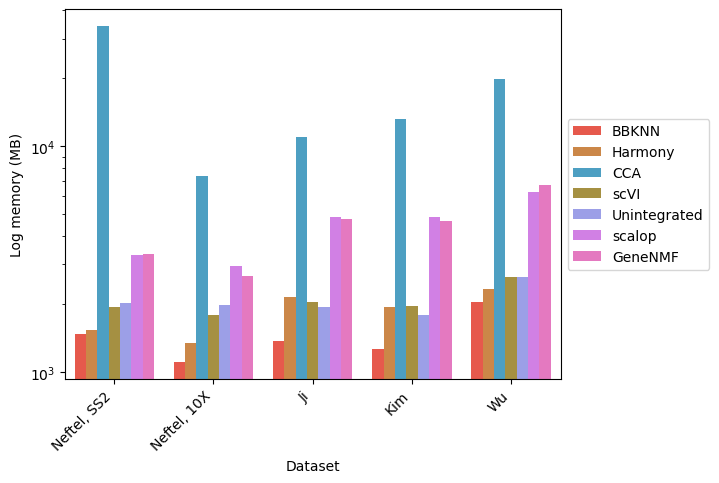

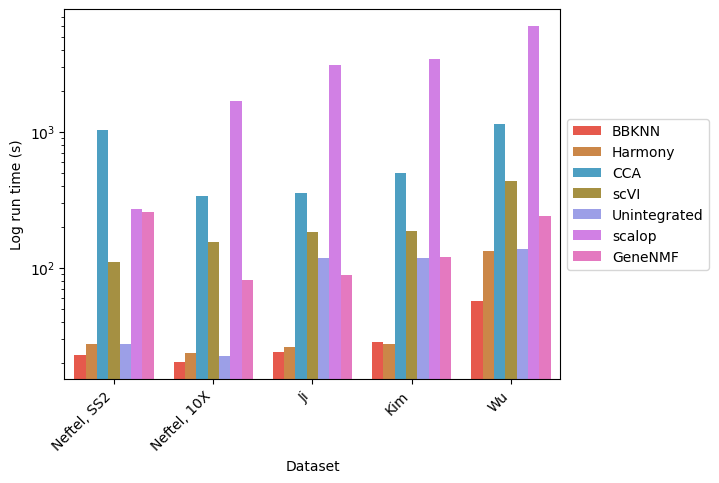

In [13]:
method_order = list(filter(lambda x: x in df["Method"].values, method_order))

fig, ax = plt.subplots()
g = sns.barplot(data=df, x='Dataset', y='memory', hue='Method', hue_order=method_order, palette=method_colormap, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
ax.set_ylabel("Log memory (MB)")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.savefig("fig_3/memory.svg", bbox_inches="tight")
plt.show();
# Adjust legend

fig, ax = plt.subplots()
g = sns.barplot(data=df, x='Dataset', y='s', hue='Method', hue_order=method_order, palette=method_colormap, ax=ax)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_yscale("log")
ax.set_ylabel("Log run time (s)")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
fig.savefig("fig_3/runtime.svg", bbox_inches="tight")
